# 6.6 Sourcing & Analyzing Time Series Data

## Table of contents
1. [Importing Libraries & Data](#imports)
2. [Subsetting, wrangling, and cleaning time-series data](#paragraph1)
3. [Time-series analysis: decomposition](#paragraph2)
4. [Testing for stationarity](#paragraph3)
5. [Stationarizing the Federal Reserve Economic Data](#paragraph4)
6. [Summary & Outlook](#paragraph5)

### 1. Importing Libraries & Data <a name="imports"></a>

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight') 

In [2]:
# Configuring API key 
quandl.ApiConfig.api_key = 'z3aEzQLVHdzvhxDJgUzG'

In [3]:
# Importing the "Consumer Price Index: Housing for Sweden" data variable.
data = quandl.get('FRED/SWECPIHOUQINMEI', collapse = 'quarterly')

In [4]:
data.head(105)

,VALUE
DATE,
1980-03-31,32.390181
1980-06-30,33.217092
1980-09-30,33.706575
1980-12-31,34.460486
1981-03-31,37.184315
...,...
2005-03-31,100.336391
2005-06-30,100.707898
2005-09-30,99.949845


#### There is no need to create a subset of the data, as there shouldnt be difference in the time periods.

In [5]:
data.shape

(141, 1)

In [6]:
data.columns

Index(['VALUE'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

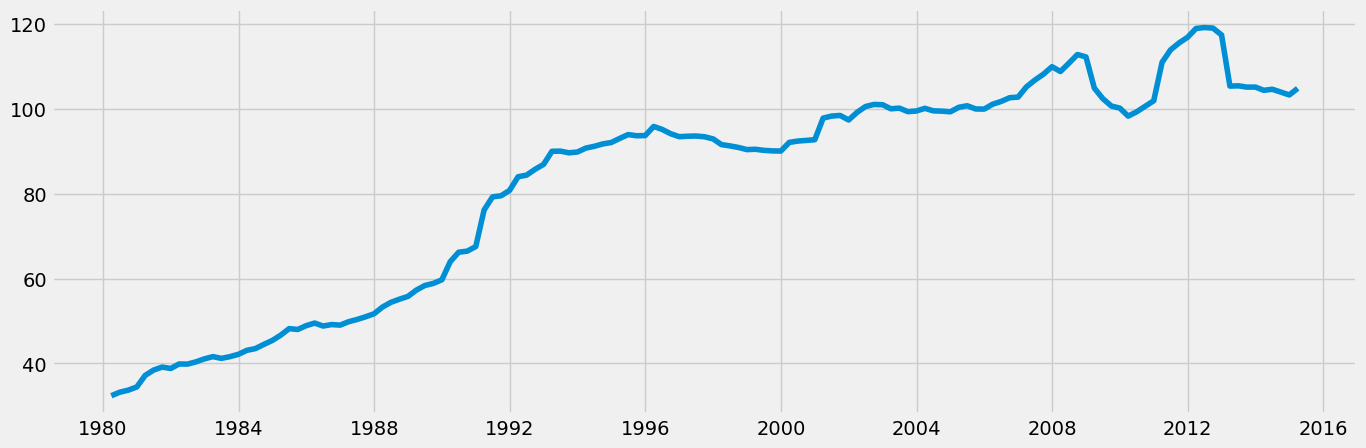

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data <a name="paragraph1"></a>

In [9]:
# Reseting index to use "Date" column as a filter
data_sub = data.reset_index()

In [10]:
data_sub.head()

,DATE,VALUE
0,1980-03-31,32.390181
1,1980-06-30,33.217092
2,1980-09-30,33.706575
3,1980-12-31,34.460486
4,1981-03-31,37.184315


In [11]:
data_sub.columns

Index(['DATE', 'VALUE'], dtype='object')

In [12]:
data_sub.rename(columns={'DATE': 'Date', 'VALUE': 'Value'}, inplace=True)

In [13]:
# Setting the "Date" column as the index
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-03-31,32.390181
1980-06-30,33.217092
1980-09-30,33.706575
1980-12-31,34.460486
1981-03-31,37.184315


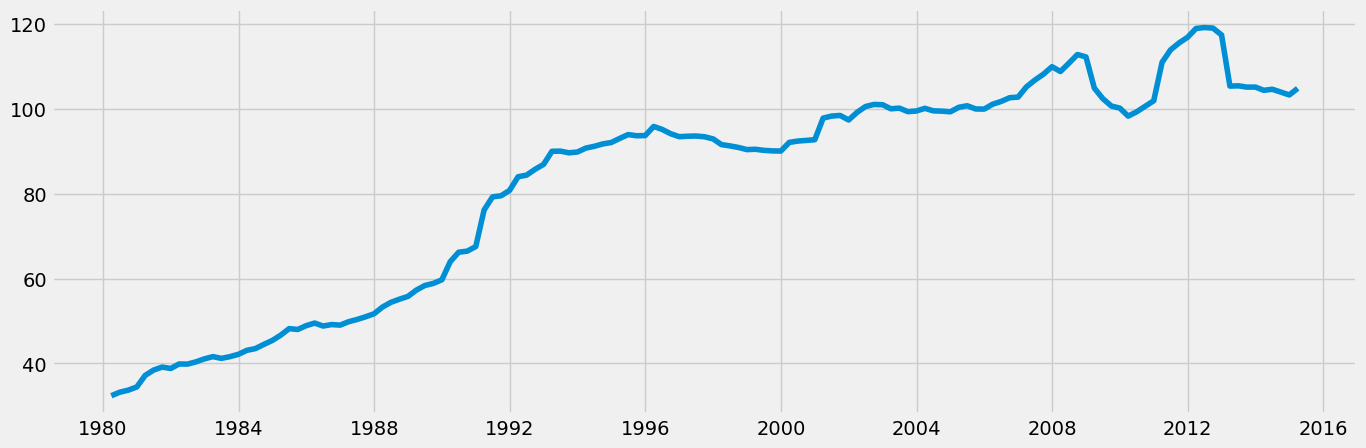

In [14]:
# Plotting  new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [15]:
# Checking for missing values
data_sub.isnull().sum() 
# No missing data

Value    0
dtype: int64

In [16]:
# Checking for duplicates
dups = data_sub.duplicated()
dups.sum()
# No dups

0

### 3. Time-series analysis: decomposition <a name="paragraph2"></a>

In [17]:
# Decomposing  time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [18]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

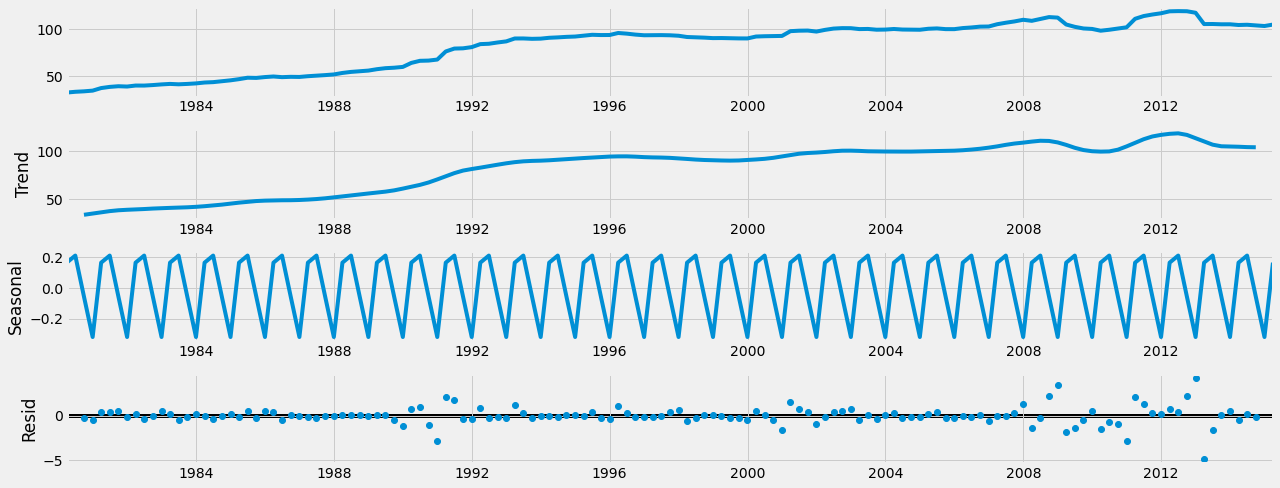

In [19]:
# Plotting separate components
decomposition.plot()
plt.show()

#### The trend in the second line chart in the above chart gradually increase in a linear fashion after 1980. While there’s one drop around 2009, likely due to the global financial crisis, the overall trend continues to increase all the way until it stagnates around 2013.
#### In the third line chart in the above chart the seasonal fluctuations are represented by a spikey curve that changes at a regular interval.
#### In the last chart the noise gets displayed.There is some unexplained noise around 1990/91 and around the 2000s likely due to global financial crisis and it's effect on the housing market. But there is more unexplained around the 2010s.

### 4. Testing for stationarity <a name="paragraph3"></a>

In [20]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.928051
p-value                          0.318982
Number of Lags Used             12.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


#### Null hypothesis: There is a presence of a unit root. 
#### Alternative hypothesis: There is no unit root.
#### With a p-value of 0.32 the test result is not significant, since it's higher than 0.05. 
#### The test statistic with -1.93 is much smaller than the critical value of -2.88 (5%), which means that the null hypothesis can’t be reject. That means that there is a unit root in the data, and the data is non-stationary

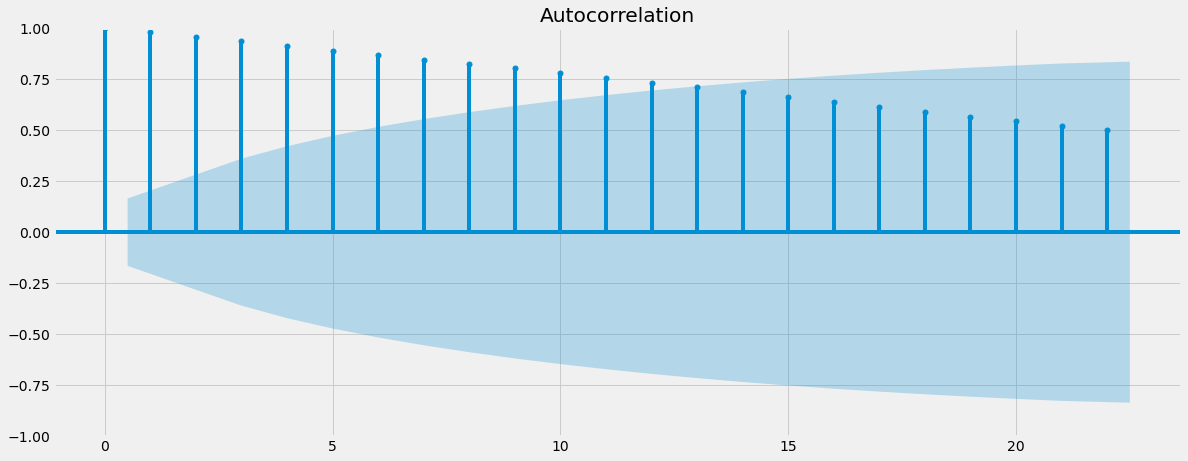

In [21]:
# Checking out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub)
plt.show()

####  The above time series has a few lags correlated with each other. This means there’s a lot of autocorrelated data and the set is likely non-stationary, confirming the result of the Dickey-Fuller test.

### 5. Stationarizing the Housing Data  <a name="paragraph4"></a>

In [22]:
# Turningn the observation to t-1, making it to t - (t -1)
data_diff = data_sub - data_sub.shift(1)

In [23]:
# Removing missing values from the result of the differencing
data_diff.dropna(inplace = True)

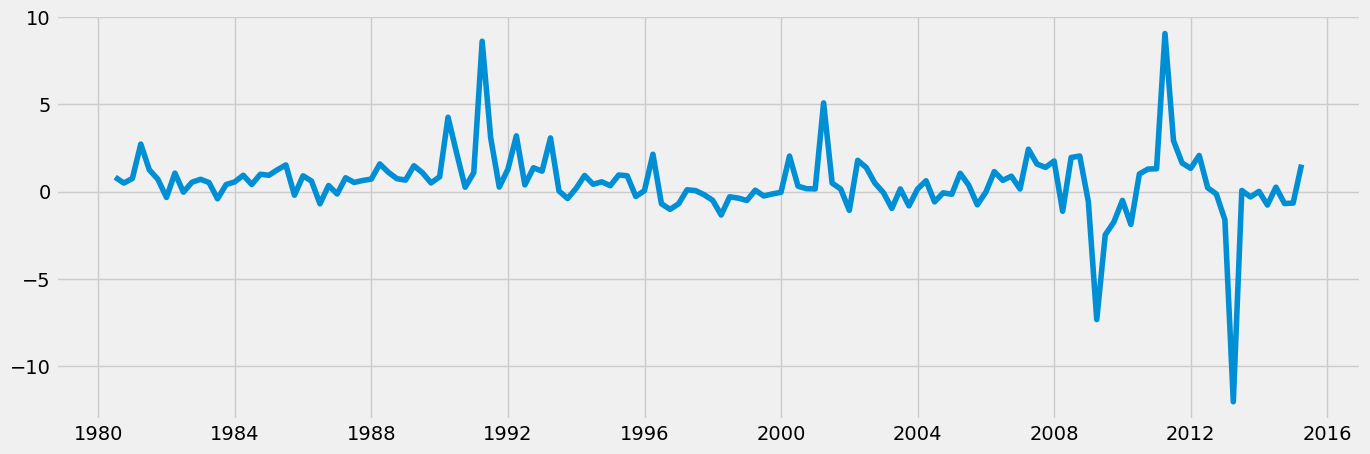

In [24]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [25]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.610302
p-value                          0.477817
Number of Lags Used             11.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


#### Null hypothesis: There is a presence of a unit root. 
#### Alternative hypothesis: There is no unit root.
#### With a p-value of 0.48 the test result is still not significant, since it's higher than 0.05. 
#### The test statistic with -1.61 is much smaller than the critical value of -2.88 (5%), which means that the null hypothesis can’t be reject. That means that there is a unit root in the data, and the data is non-stationary

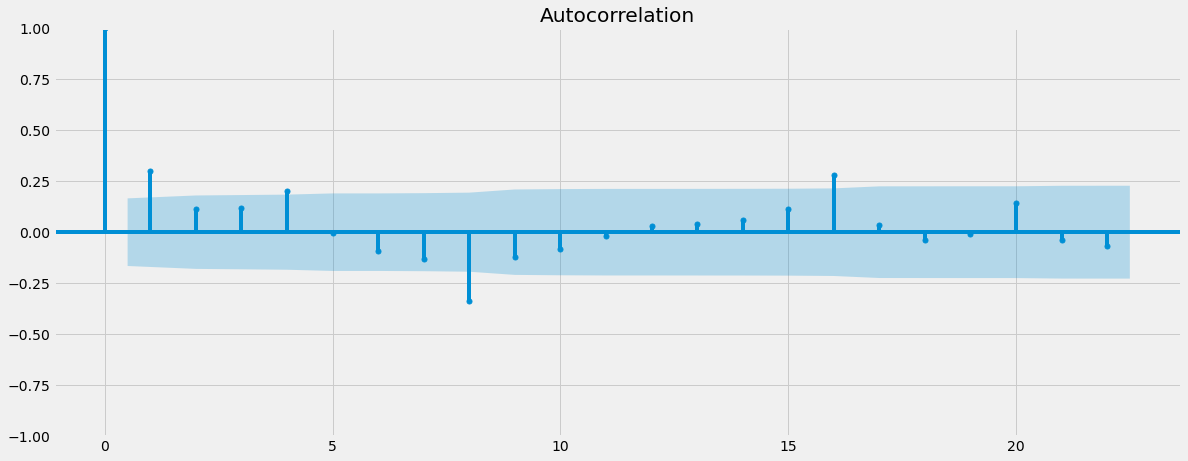

In [26]:
plot_acf(data_diff)
plt.show()